In [7]:
#export
using JSON, DelimitedFiles, Images, DICOM, ImageMagick, CSV
export notebook2script, visualize

In [8]:
#export
function notebook2script(nb)
    url = replace(nb, ".ipynb"=>".jl")
    name = titlecase(match(r"(?<=\/).[^\/]+(?=.ipynb)", nb).match)
    script = []
    open(nb) do file
        for cell in JSON.parse(file)["cells"]
            if length(cell["source"])>0 && cell["source"][1] == "#export\n"
                push!(script, "", strip.(cell["source"][2:end], '\n'))
            end
        end
    end
    template = "# Automatically generated file, do not edit!"
    script = [template; script...]
    writedlm(url, script, quotes=false)
end

notebook2script (generic function with 1 method)

In [9]:
#export
function opendcm(filename)
    filename|> DICOM.dcm_parse |> x->(x)[tag"Pixel Data"] |> ImageMagick.load_
end

opendcm (generic function with 1 method)

In [10]:
img = opendcm("/code/Kaggle/data/samples/1.2.276.0.7230010.3.1.4.8323329.4440.1517875182.865105.dcm");

In [11]:
annotations = CSV.read("D:/code/Kaggle/data/samples/train-rle-sample.csv");

In [12]:
#export
function rle2mask(rle, size)
    mask = Bool.(zeros(Int, size))
    rle = parse.(Int, split(rle))
    if rle[1] == -1 return mask end
    count = 0
    for i in 1:2:length(rle)
        count += rle[i]
        mask[count:count+rle[i+1]] .= 1
        count += rle[i+1]
    end
    return mask
end
    
function mask2rle(mask, string=true)
    rle = []
    count = 0
    while true
        masked = findnext(mask, count+1)
        if isnothing(masked) break end
        
        unmasked = findnext(.!mask, masked)
        if isnothing(unmasked) unmasked = length(mask) end
            
        push!(rle, masked-count, unmasked-1-masked)
        count = unmasked-1
    end
    if isempty(rle) rle = [-1] end
    if string rle = join(rle, " ") end
    return rle
end

mask2rle (generic function with 2 methods)

In [13]:
nr = 6
img = opendcm("D:/code/Kaggle/data/samples/"*annotations[nr,1]*".dcm")
mask = rle2mask(annotations[nr, 2], (1024,1024));

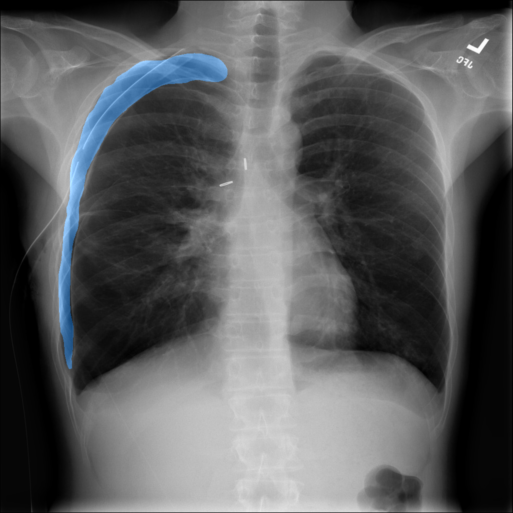

In [14]:
colorview(RGB, img, img.+0.2.*mask, img.+0.4.*mask)

In [15]:
#export
visualize(img::I, mask::M) where {I, M <: AbstractArray} = colorview(RGB, img, img.+0.2.*mask, img.+0.4.*mask)

function visualize(imgid::T, rlemask::T; datapath="D:/code/kaggle/data/samples"::String) where {T <: String}
    img = opendcm(datapath*"/"*imgid*".dcm")
    mask = rle2mask(rlemask, size(img))
    visualize(img, mask)
end

function visualize(imgid::T, rlemask::T, id2path::Dict) where {T <: String}
    img = opendcm(id2path[imgid])
    mask = rle2mask(rlemask, size(img))
    visualize(img, mask)
end

visualize (generic function with 3 methods)

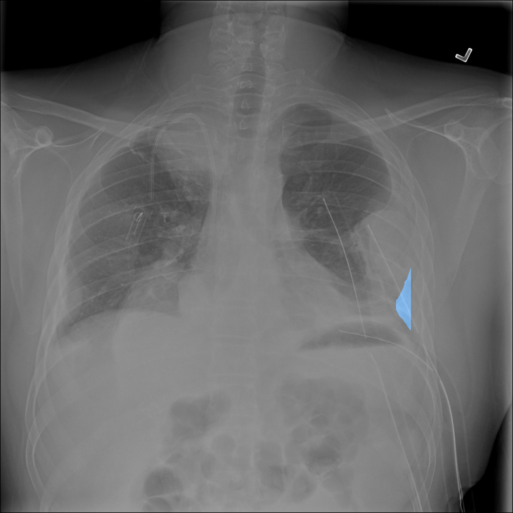

In [16]:
visualize(annotations[9, :]...)

In [17]:
match(r"(?<=\/).[^\/]+(?=.ipynb)", "/code/Kaggle/utilities.ipynb").match

"utilities"

In [18]:
notebook2script("/code/Kaggle/utilities.ipynb")